## Deep Learning Course Project - Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [1]:
# Importing the necessary libraries

import numpy as np
import os
import imageio
from skimage.transform import resize

import cv2
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30) # Use tf.random.set_seed to set the global random seed in TensorFlow

In [3]:
import cv2
import matplotlib.pyplot as plt

In [4]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, LSTM # Import LSTM directly from keras.layers
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D # Import convolutional layers from tensorflow.keras.layers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from keras.layers import Dropout

In [5]:
project_folder='datasets/Project_data'

In [6]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [7]:
# Generator

class ModelBuilder(metaclass=abc.ABCMeta):
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path = project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def initialize_image_properties(self, image_height=100, image_width=100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30

    def initialize_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    # MOST IMPORTANT PART HERE - The generator function
    def generator(self, source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size

            for batch in range(num_batches): 
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels 

            remaining_seq = len(t) % batch_size

            if remaining_seq != 0:
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels 

    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        seq_len = remaining_seq if remaining_seq else batch_size
        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_len, self.num_classes)) 

        if augment:
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        for folder in range(seq_len): 
            imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx):
                # Performing image reading and resizing using imageio and skimage
                image = imageio.imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))

                # Normalizing the images
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

                if augment:
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]), 
                                             (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 

                    # Cropping the images to focus on gestures and remove noise
                    cropped = shifted[x0:x1, y0:y1, :]
                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))

                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

        if augment:
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        return batch_data, batch_labels

    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences / self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1
    
        history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                                      callbacks=callbacks_list, validation_data=val_generator, 
                                      validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history
        
    @abc.abstractmethod
    def define_model(self):
        pass

## MODEL

In [10]:
#Sample_Model

class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

2024-09-03 18:10:28.918082: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-09-03 18:10:28.918145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


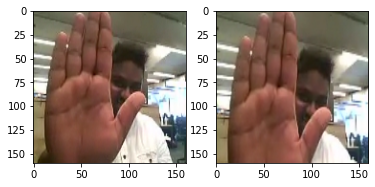

In [12]:
test_generator = ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160, image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30, batch_size=3, num_epochs=1)

g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=True)
batch_data, batch_labels = next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0, 15, :, :, :])   
axes[1].imshow(batch_data[3, 15, :, :, :])  

## Image Resolutions Experiments

### Image Resolution

In [13]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


So lets trade-off between these parameters
Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

## Model 1
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [16]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_9 (Activation)   (None, 10, 80, 80, 32)   

In [18]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5670 - categorical_accuracy: 0.4163
Epoch 00001: val_loss improved from inf to 3.34671, saving model to model_init_2024-09-0318_12_35.479683/model-00001-1.56697-0.41629-3.34671-0.23000.h5
17/17 [==============================] - 121s 7s/step - loss: 1.5670 - categorical_accuracy: 0.4163 - val_loss: 3.3467 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.1540 - categorical_accuracy: 0.5415
Epoch 00002: val_loss improved from 3.34671 to 1.68605, saving model to model_init_2024-09-0318_12_35.479683/model-00002-1.15395-0.54148-1.68605-0.36000.h5
17/17 [==============================] - 118s 7s/step - loss: 1.1540 - categorical_accuracy: 0.5415 - val_loss: 1.6860 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.8489 - categorical_accuracy: 0.6561
Epoch 00003: val_l

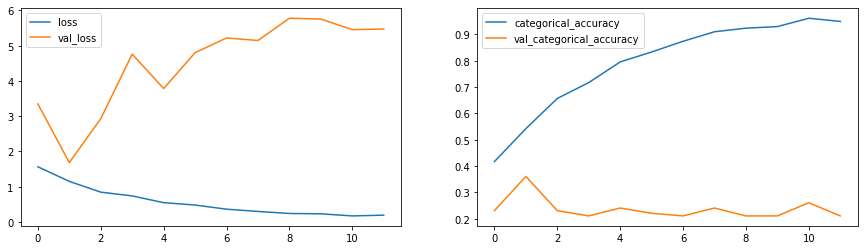

In [23]:
plot(history_model1)

In [24]:
## Model 2
### Adding Dropout layers - Batch Size = 20 and No. of Epochs = 25

In [25]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_13 (Activation)  (None, 10, 80, 80, 32)   

In [26]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9318 - categorical_accuracy: 0.4057
Epoch 00001: val_loss improved from inf to 3.00192, saving model to model_init_2024-09-0318_41_22.869649/model-00001-1.93177-0.40573-3.00192-0.19000.h5
34/34 [==============================] - 221s 7s/step - loss: 1.9318 - categorical_accuracy: 0.4057 - val_loss: 3.0019 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4297 - categorical_accuracy: 0.5053
Epoch 00002: val_loss did not improve from 3.00192
34/34 [==============================] - 223s 7s/step - loss: 1.4297 - categorical_accuracy: 0.5053 - val_loss: 4.0033 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1958 - categorical_accuracy: 0.5928
Epoch 00003: val_loss did not improve from 3.00192
34/34 [==============================] - 220s 7s/step - loss: 1.1958 - c

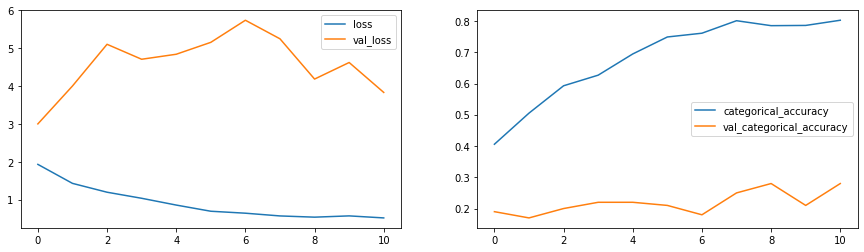

In [28]:
plot(history_model2)

We can see val_loss did not improve from 1.24219 so earlystopping stops the epoch automatically!!
Last Epoch stop on 15/25!! good job earlystopping ;)
Best weights save automatically. The validation accuracy of 52% and training accuracy of 65%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations in loss, let's try lowering the learning rate to 0.0002

## Model 3
### Reduce filter size to (2,2,2) and image res to 120 x 120, - Batch Size = 30 and No. of Epochs = 25

In [29]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_16 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_17 (Activation)  (None, 8, 60, 60, 32)    

In [31]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.0957 - categorical_accuracy: 0.3258
Epoch 00001: val_loss improved from inf to 1.85639, saving model to model_init_2024-09-0319_21_49.075410/model-00001-2.09572-0.32579-1.85639-0.16000.h5
23/23 [==============================] - 155s 7s/step - loss: 2.0957 - categorical_accuracy: 0.3258 - val_loss: 1.8564 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.5133 - categorical_accuracy: 0.4698
Epoch 00002: val_loss did not improve from 1.85639
23/23 [==============================] - 153s 7s/step - loss: 1.5133 - categorical_accuracy: 0.4698 - val_loss: 2.5761 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.2319 - categorical_accuracy: 0.5468
Epoch 00003: val_loss did not improve from 1.85639
23/23 [==============================] - 155s 7s/step - loss: 1.

Model has a best validation accuracy of 72% and training accuracy of 76% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers


## Model 4
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [33]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [34]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_21 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_21 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_31 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [35]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9914 - categorical_accuracy: 0.3477
Epoch 00001: val_loss improved from inf to 2.68436, saving model to model_init_2024-09-0319_50_04.100224/model-00001-1.99143-0.34766-2.68436-0.16000.h5
34/34 [==============================] - 158s 5s/step - loss: 1.9914 - categorical_accuracy: 0.3477 - val_loss: 2.6844 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5926 - categorical_accuracy: 0.4600
Epoch 00002: val_loss did not improve from 2.68436
34/34 [==============================] - 158s 5s/step - loss: 1.5926 - categorical_accuracy: 0.4600 - val_loss: 4.3181 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2613 - categorical_accuracy: 0.5732
Epoch 00003: val_loss did not improve from 2.68436
34/34 [==============================] - 155s 5s/step - loss: 1.2613 - c

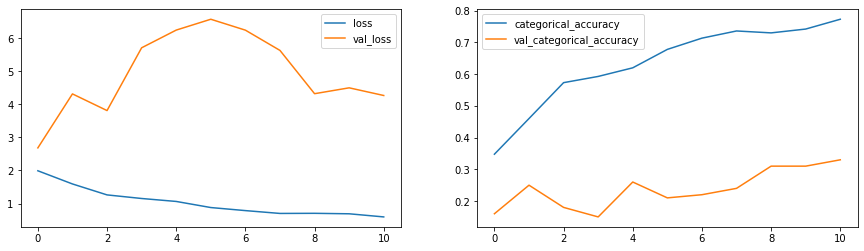

In [36]:

plot(history_model4)

With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

## Model 8 - CNN- LSTM Model

In [18]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 18, 120, 120, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 18, 60, 60, 32)  

In [39]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3840 - categorical_accuracy: 0.3997
Epoch 00001: val_loss improved from inf to 1.66651, saving model to model_init_2024-09-0320_18_49.367314/model-00001-1.38398-0.39970-1.66651-0.22000.h5
34/34 [==============================] - 181s 5s/step - loss: 1.3840 - categorical_accuracy: 0.3997 - val_loss: 1.6665 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1536 - categorical_accuracy: 0.5166
Epoch 00002: val_loss did not improve from 1.66651
34/34 [==============================] - 176s 5s/step - loss: 1.1536 - categorical_accuracy: 0.5166 - val_loss: 2.0507 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9758 - categorical_accuracy: 0.6131
Epoch 00003: val_loss did not improve from 1.66651
34/34 [==============================] - 175s 5s/step - loss: 0.9758 - c

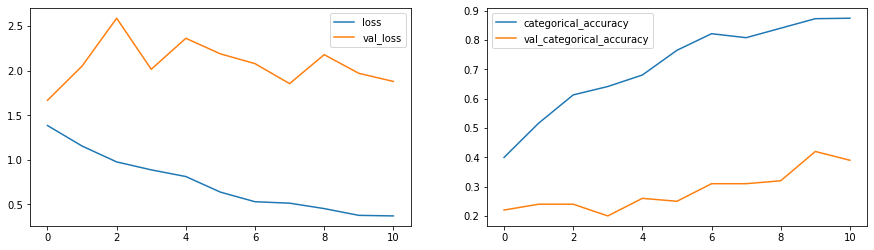

In [40]:
plot(history_model8)

For CNN - LSTM model we get a best validation accuracy of 85%
As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again

## Let's apply some data augmentation & check the model performance.

In [11]:
class ModelBuilderMoreAugmentation(metaclass=abc.ABCMeta):

    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path = project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def initialize_image_properties(self, image_height=100, image_width=100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30

    def initialize_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    def generator(self, source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size

            for batch in range(num_batches):
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels

            remaining_seq = len(t) % batch_size

            if remaining_seq != 0:
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels

    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))
        batch_labels = np.zeros((seq_len, self.num_classes))

        if augment:
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        for folder in range(seq_len):
            imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx):
                image_path = source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]
                image = cv2.imread(image_path).astype(np.float32)

                # Resize image
                image_resized = cv2.resize(image, (self.image_height, self.image_width))

                # Normalize image
                batch_data[folder, idx, :, :, 0] = image_resized[:, :, 0] / 255
                batch_data[folder, idx, :, :, 1] = image_resized[:, :, 1] / 255
                batch_data[folder, idx, :, :, 2] = image_resized[:, :, 2] / 255

                if augment:
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]),
                                             (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped = shifted[x0:x1, y0:y1, :]

                    image_resized = cv2.resize(cropped, (self.image_height, self.image_width))

                    M = cv2.getRotationMatrix2D((self.image_width // 2, self.image_height // 2),
                                                np.random.randint(-10, 10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))

                    batch_data_aug[folder, idx, :, :, 0] = rotated[:, :, 0] / 255
                    batch_data_aug[folder, idx, :, :, 1] = rotated[:, :, 1] / 255
                    batch_data_aug[folder, idx, :, :, 2] = rotated[:, :, 2] / 255

            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

        if augment:
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        return batch_data, batch_labels

    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences / self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                                      callbacks=callbacks_list, validation_data=val_generator,
                                      validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

    @abc.abstractmethod
    def define_model(self):
        pass

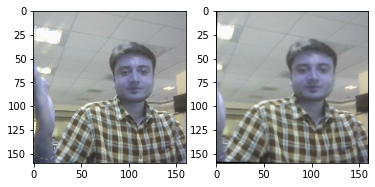

In [12]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

Start with Model 9

## Model 9 with Augmentation
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [13]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)    0

2024-09-04 03:39:59.543010: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-09-04 03:39:59.543073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [15]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20


2024-09-04 03:40:37.119796: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.9996 - categorical_accuracy: 0.3876
Epoch 00001: saving model to model_init_2024-09-0403_40_30.974959/model-00001-1.99959-0.38763-2.49375-0.16000.h5
34/34 [==============================] - 117s 3s/step - loss: 1.9996 - categorical_accuracy: 0.3876 - val_loss: 2.4938 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4804 - categorical_accuracy: 0.4864
Epoch 00002: saving model to model_init_2024-09-0403_40_30.974959/model-00002-1.48039-0.48643-3.72186-0.22000.h5
34/34 [==============================] - 90s 3s/step - loss: 1.4804 - categorical_accuracy: 0.4864 - val_loss: 3.7219 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.2566 - categorical_accuracy: 0.5535
Epoch 00003: saving model to model_init_2024-09-0403_40_30.974959/model-00003-1.25658-0.55354-4.95992-0.22000.h5
34/34 [======

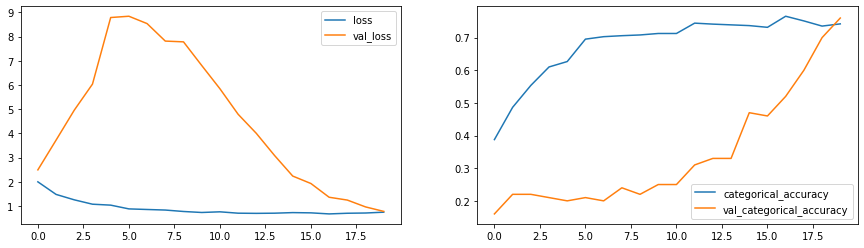

In [16]:
plot(history_model9)

Model 10 with Augmentation
(2,2,2) Filter & 120x120 Image resolution - similar to Model 3

In [12]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  400       
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)     0

2024-09-04 05:35:43.600253: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-09-04 05:35:43.600317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [15]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25


2024-09-04 05:36:11.561640: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 2.1699 - categorical_accuracy: 0.3243
Epoch 00001: saving model to model_init_2024-09-0405_36_06.448219/model-00001-2.16988-0.32428-1.91599-0.16000.h5
23/23 [==============================] - 60s 2s/step - loss: 2.1699 - categorical_accuracy: 0.3243 - val_loss: 1.9160 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.4230 - categorical_accuracy: 0.4910
Epoch 00002: saving model to model_init_2024-09-0405_36_06.448219/model-00002-1.42303-0.49095-2.52144-0.19000.h5
23/23 [==============================] - 56s 3s/step - loss: 1.4230 - categorical_accuracy: 0.4910 - val_loss: 2.5214 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.2552 - categorical_accuracy: 0.5551
Epoch 00003: saving model to model_init_2024-09-0405_36_06.448219/model-00003-1.25515-0.55505-3.32237-0.12000.h5
23/23 [=======

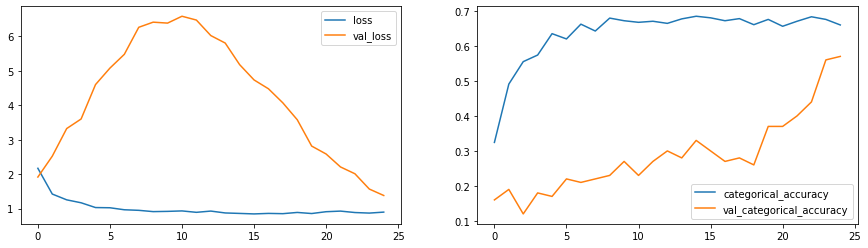

In [ ]:
plot(history_model10)

## Model 11 with Augmentation
### Adding more layers - Similar to model 4

In [ ]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_5 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_7 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                      

In [ ]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0399 - categorical_accuracy: 0.3303
Epoch 00001: saving model to model_init_2024-09-0406_00_01.969136/model-00001-2.03994-0.33032-2.01366-0.21000.h5
34/34 [==============================] - 66s 2s/step - loss: 2.0399 - categorical_accuracy: 0.3303 - val_loss: 2.0137 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5649 - categorical_accuracy: 0.4721
Epoch 00002: saving model to model_init_2024-09-0406_00_01.969136/model-00002-1.56491-0.47210-2.99848-0.26000.h5
34/34 [==============================] - 61s 2s/step - loss: 1.5649 - categorical_accuracy: 0.4721 - val_loss: 2.9985 - val_categorical_accuracy: 0.2600 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3333 - categorical_accuracy: 0.5332
Epoch 00003: saving model to model_init_2024-09-0406_00_01.969136/model-00003-1.33327-0.53318-

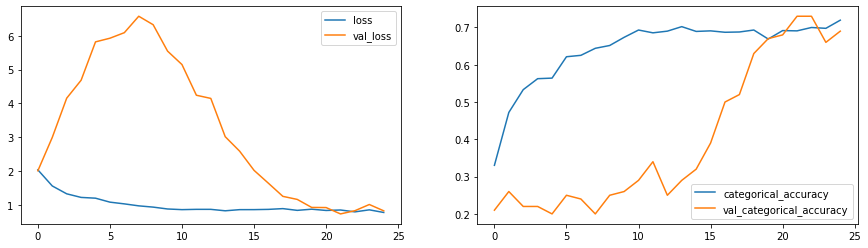

In [ ]:
plot(history_model11)

##Model 12 with Augmentation
Adding dropouts - Similar to Model 5

In [ ]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_20 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_13 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_21 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [ ]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9866 - categorical_accuracy: 0.3296
Epoch 00001: saving model to model_init_2024-09-0406_47_11.413912/model-00001-1.98660-0.32956-2.04575-0.16000.h5
34/34 [==============================] - 62s 2s/step - loss: 1.9866 - categorical_accuracy: 0.3296 - val_loss: 2.0457 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5393 - categorical_accuracy: 0.4261
Epoch 00002: saving model to model_init_2024-09-0406_47_11.413912/model-00002-1.53930-0.42609-3.17690-0.17000.h5
34/34 [==============================] - 59s 2s/step - loss: 1.5393 - categorical_accuracy: 0.4261 - val_loss: 3.1769 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2964 - categorical_accuracy: 0.5136
Epoch 00003: saving model to model_init_2024-09-0406_47_11.413912/model-00003-1.29639-0.51357-

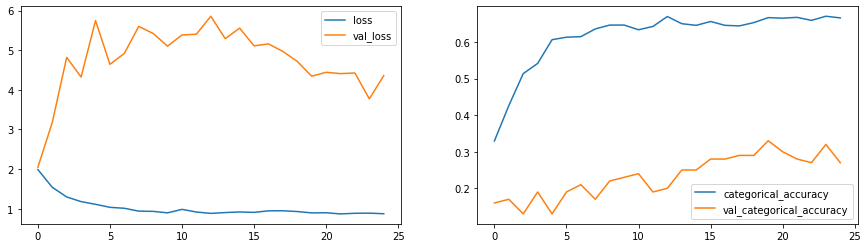

In [45]:
plot(history_model12)

## Model 14 with Augmentation
Reducing network parameters again - Similar to model 7

In [46]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [47]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_39 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_25 (Activation)  (None, 8, 60, 60, 32)    

In [48]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7453 - categorical_accuracy: 0.3620
Epoch 00001: saving model to model_init_2024-09-0408_29_46.036931/model-00001-1.74535-0.36199-1.83419-0.21000.h5
34/34 [==============================] - 76s 2s/step - loss: 1.7453 - categorical_accuracy: 0.3620 - val_loss: 1.8342 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2669 - categorical_accuracy: 0.5143
Epoch 00002: saving model to model_init_2024-09-0408_29_46.036931/model-00002-1.26688-0.51433-2.36328-0.22000.h5
34/34 [==============================] - 68s 2s/step - loss: 1.2669 - categorical_accuracy: 0.5143 - val_loss: 2.3633 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0989 - categorical_accuracy: 0.5709
Epoch 00003: saving model to model_init_2024-09-0408_29_46.036931/model-00003-1.09891-0.57089-3

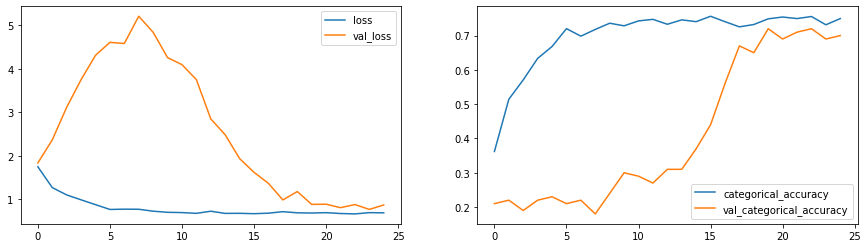

In [49]:
plot(history_model14)

## Model 15 with Augmentation
CNN LSTM with GRU - Similar to Model 8

In [18]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [22]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4725 - categorical_accuracy: 0.3869
Epoch 00001: saving model to model_init_2024-09-0406_24_52.999226/model-00001-1.47246-0.38688-1.72871-0.17000.h5
34/34 [==============================] - 68s 2s/step - loss: 1.4725 - categorical_accuracy: 0.3869 - val_loss: 1.7287 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0903 - categorical_accuracy: 0.5777
Epoch 00002: saving model to model_init_2024-09-0406_24_52.999226/model-00002-1.09033-0.57768-2.00113-0.14000.h5
34/34 [==============================] - 65s 2s/step - loss: 1.0903 - categorical_accuracy: 0.5777 - val_loss: 2.0011 - val_categorical_accuracy: 0.1400 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8843 - categorical_accuracy: 0.6621
Epoch 00003: saving model to model_init_2024-09-0406_24_52.999226/model-00003-0.88434-0.66214-

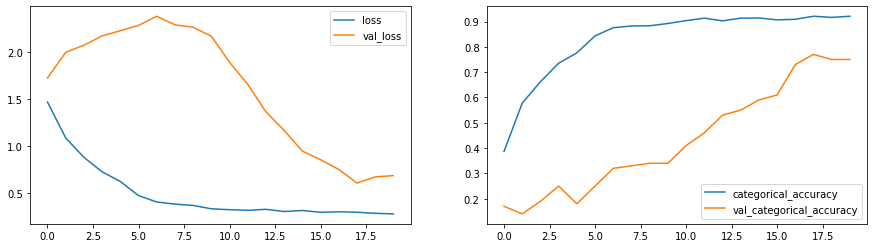

In [24]:
plot(history_model15)

## We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy
## Model 16 - Let us bring in Transfer Learning !! :)
(Optional)

In [26]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 

from keras.applications import mobilenet

In [37]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [38]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)              

In [39]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4223 - categorical_accuracy: 0.4027
Epoch 00001: saving model to model_init_2024-09-0407_38_05.072423/model-00001-1.42227-0.40271-0.97877-0.67000.h5
133/133 [==============================] - 61s 444ms/step - loss: 1.4223 - categorical_accuracy: 0.4027 - val_loss: 0.9788 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9555 - categorical_accuracy: 0.6154
Epoch 00002: saving model to model_init_2024-09-0407_38_05.072423/model-00002-0.95550-0.61538-0.71149-0.74000.h5
133/133 [==============================] - 56s 425ms/step - loss: 0.9555 - categorical_accuracy: 0.6154 - val_loss: 0.7115 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.7972 - categorical_accuracy: 0.6998
Epoch 00003: saving model to model_init_2024-09-0407_38_05.072423/model-00003-0.79720-

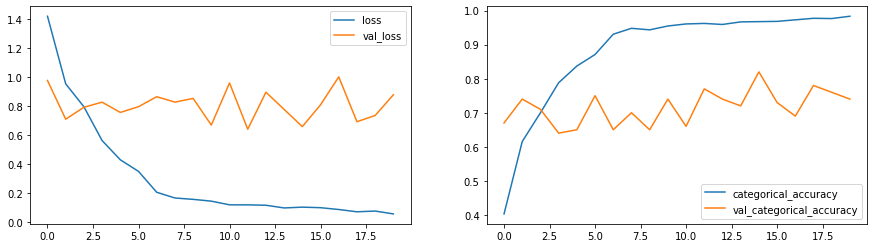

In [40]:
plot(history_model16)

## We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement
## Model 17 - Transfer Learning with GRU and training all weights
(Optional)

In [15]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               4

In [43]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2601 - categorical_accuracy: 0.4789
Epoch 00001: saving model to model_init_2024-09-0407_56_47.088820/model-00001-1.26014-0.47888-0.91212-0.64000.h5
133/133 [==============================] - 62s 443ms/step - loss: 1.2601 - categorical_accuracy: 0.4789 - val_loss: 0.9121 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6869 - categorical_accuracy: 0.7179
Epoch 00002: saving model to model_init_2024-09-0407_56_47.088820/model-00002-0.68685-0.71795-0.50910-0.81000.h5
133/133 [==============================] - 56s 424ms/step - loss: 0.6869 - categorical_accuracy: 0.7179 - val_loss: 0.5091 - val_categorical_accuracy: 0.8100 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5425 - categorical_accuracy: 0.8069
Epoch 00003: saving model to model_init_2024-09-0407_56_47.088820/model-00003-0.54250-

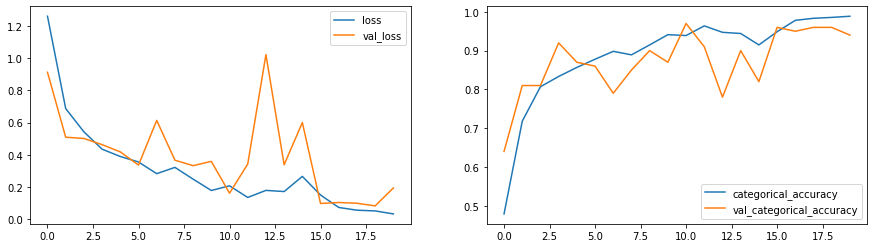

In [44]:
plot(history_model17)

After doing all the experiments, we finalized Model 17 - CNN+LSTM, which performed well.
Reason:

- (Training Accuracy : 98.87%, Validation Accuracy : 94%)

- Number of Parameters(1,657,445)less according to other models performance

- Learning rate remained same after 16th Epoch

## Loading model and Testing

In [13]:
import time
from keras.models import load_model
model = load_model('model_init_2024-09-0407_56_47.088820/model-00020-0.03293-0.98869-0.19412-0.94000.h5')

In [20]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [21]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])